In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display, clear_output
from scipy.signal import spectrogram
import ipywidgets as widgets
import time


# --- Quantization Function ---
def quantize(voltage, bits, v_min, v_max):
   levels = 2 ** bits
   step = (v_max - v_min) / levels
   quantized = round((voltage - v_min) / step) * step + v_min
   return quantized, step


# --- Easing Function (Ease In-Out Cubic) ---
def ease_in_out(t):
   return 3 * t**2 - 2 * t**3

# --- Widgets ---
v_min_widget = widgets.FloatText(value=0.0, description="Min V:")
v_max_widget = widgets.FloatText(value=5.0, description="Max V:")
voltage_widget = widgets.FloatText(value=2.5, description="Analog V:")
bits_widget = widgets.IntText(value=3, description="Bits:")
sample_rate_widget = widgets.FloatText(value=1.0, description="Sample Rate (kHz):")
run_button = widgets.Button(description="Start Quantization")


# --- UI Layout ---
ui = widgets.VBox([
   v_min_widget,
   v_max_widget,
   voltage_widget,
   bits_widget,
   sample_rate_widget,
   run_button
])
display(ui)


# --- Callback ---
def on_button_click(b):
   clear_output(wait=True)
   display(ui)


   # Get values
   v_min = v_min_widget.value
   v_max = v_max_widget.value
   voltage = voltage_widget.value
   bits = bits_widget.value
   sample_rate_khz = sample_rate_widget.value


   # Quantize
   q_val, step = quantize(voltage, bits, v_min, v_max)
   error = voltage - q_val
   levels = np.linspace(v_min, v_max, 2 ** bits)


   # --- Animation Setup ---
   fig, ax = plt.subplots(figsize=(6, 4))
   ax.set_title("Quantization Animation")
   ax.set_xlim(0, 1)
   ax.set_ylim(v_min - 0.5, v_max + 0.5)


   for level in levels:
       ax.hlines(level, 0, 1, colors='lightgray', linestyles='dotted')


   analog_dot, = ax.plot([], [], 'bo', label='Analog Voltage')
   quant_dot, = ax.plot([], [], 'ro', label='Quantized Value')
   error_arrow = ax.annotate('', xy=(0.5, 0), xytext=(0.5, 0),
                             arrowprops=dict(arrowstyle='<->', color='red'),
                             fontsize=12)


   ax.legend()


   frames = 60
   t_vals = np.linspace(0, 1, frames)
   eased_voltages = v_min + (voltage - v_min) * ease_in_out(t_vals)


   def init():
       analog_dot.set_data([], [])
       quant_dot.set_data([], [])
       error_arrow.set_visible(False)
       return analog_dot, quant_dot, error_arrow


   def update(frame):
       analog_dot.set_data([0.5], [eased_voltages[frame]])
       if frame == frames - 1:
           quant_dot.set_data([0.5], [q_val])


           # Draw error arrow
           error_arrow.set_visible(True)
           error_arrow.set_position((0.5, (voltage + q_val)/2))
           error_arrow.xy = (0.5, voltage)
           error_arrow.xytext = (0.5, q_val)
           error_arrow.set_text(f"Error: {error:.2f} V")
       return analog_dot, quant_dot, error_arrow


   ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init,
                                 blit=True, repeat=False)


   plt.close(fig)
   display(HTML(ani.to_jshtml()))


   # --- Pause before showing spectrogram ---
   time.sleep(1.2)


   # --- Spectrogram ---
   t = np.linspace(0, 1, 1000)
   signal = np.sin(2 * np.pi * 10 * t) * ((voltage - v_min) / (v_max - v_min))
   fs = int(sample_rate_khz * 1000)
   f, t_spec, Sxx = spectrogram(signal, fs=fs)


   plt.figure(figsize=(8, 4))
   plt.title("Spectrogram of Input Signal")
   plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
   plt.ylabel('Frequency [Hz]')
   plt.xlabel('Time [sec]')
   plt.colorbar(label='Power [dB]')
   plt.tight_layout()
   plt.show()


run_button.on_click(on_button_click)

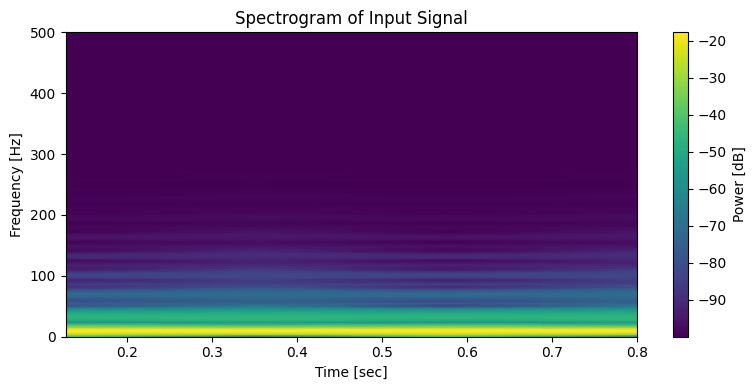

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display, clear_output
from scipy.signal import spectrogram
import ipywidgets as widgets
import time


# --- Quantization Function ---
def quantize(voltage, bits, v_min, v_max):
    levels = 2 ** bits
    step = (v_max - v_min) / levels
    # Clamp voltage to range before quantizing to avoid extrapolation
    voltage_clamped = np.clip(voltage, v_min, v_max)
    quantized = round((voltage_clamped - v_min) / step) * step + v_min
    return quantized, step


# --- Easing Function (Ease In-Out Cubic) ---
def ease_in_out(t):
    return 3 * t**2 - 2 * t**3


# --- Widgets ---
v_min_widget = widgets.FloatText(value=0.0, description="Min V:")
v_max_widget = widgets.FloatText(value=5.0, description="Max V:")
voltage_widget = widgets.FloatText(value=2.5, description="Analog V:")
bits_widget = widgets.IntText(value=3, description="Bits:")
sample_rate_widget = widgets.FloatText(value=1.0, description="Sample Rate (kHz):")
run_button = widgets.Button(description="Start Quantization")
output_warning = widgets.HTML(value="")  # For warnings


# --- UI Layout ---
ui = widgets.VBox([
    v_min_widget,
    v_max_widget,
    voltage_widget,
    bits_widget,
    sample_rate_widget,
    run_button,
    output_warning
])
display(ui)


# --- Callback ---
def on_button_click(b):
    clear_output(wait=True)
    display(ui)

    # Get values
    v_min = v_min_widget.value
    v_max = v_max_widget.value
    voltage = voltage_widget.value
    bits = bits_widget.value
    sample_rate_khz = sample_rate_widget.value

    # Input validation
    if v_max <= v_min:
        output_warning.value = "<b style='color:red'>Error: Max V must be greater than Min V.</b>"
        return
    if bits < 1:
        output_warning.value = "<b style='color:red'>Error: Bits must be at least 1.</b>"
        return
    if sample_rate_khz <= 0:
        output_warning.value = "<b style='color:red'>Error: Sample rate must be positive.</b>"
        return

    # Check if voltage is outside range
    if voltage < v_min or voltage > v_max:
        output_warning.value = (
            f"<b style='color:orange'>Warning: Input voltage {voltage} V outside range [{v_min}, {v_max}]. "
            "It will be clamped for quantization.</b>"
        )
    else:
        output_warning.value = ""

    # Quantize (clamping inside quantize function)
    q_val, step = quantize(voltage, bits, v_min, v_max)
    error = voltage - q_val
    levels = np.linspace(v_min, v_max, 2 ** bits)

    # Determine y-axis limits dynamically to fit voltage & quantized point with margin
    y_min = min(v_min, voltage, q_val) - 0.5
    y_max = max(v_max, voltage, q_val) + 0.5

    # --- Animation Setup ---
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title("Quantization Animation")
    ax.set_xlim(0, 1)
    ax.set_ylim(y_min, y_max)

    for level in levels:
        ax.hlines(level, 0, 1, colors='lightgray', linestyles='dotted')

    analog_dot, = ax.plot([], [], 'bo', label='Analog Voltage')
    quant_dot, = ax.plot([], [], 'ro', label='Quantized Value')
    error_arrow = ax.annotate('', xy=(0.5, 0), xytext=(0.5, 0),
                              arrowprops=dict(arrowstyle='<->', color='red'),
                              fontsize=12)
    ax.legend()

    frames = 60
    t_vals = np.linspace(0, 1, frames)
    eased_voltages = y_min + (voltage - y_min) * ease_in_out(t_vals)  # Ease from y_min for visible animation

    def init():
        analog_dot.set_data([], [])
        quant_dot.set_data([], [])
        error_arrow.set_visible(False)
        return analog_dot, quant_dot, error_arrow

    def update(frame):
        analog_dot.set_data([0.5], [eased_voltages[frame]])
        if frame == frames - 1:
            quant_dot.set_data([0.5], [q_val])

            # Draw error arrow only if there is an error (non-zero)
            if abs(error) > 1e-9:
                error_arrow.set_visible(True)
                error_arrow.set_position((0.5, (voltage + q_val) / 2))
                error_arrow.xy = (0.5, voltage)
                error_arrow.xytext = (0.5, q_val)
                error_arrow.set_text(f"Error: {error:.2f} V")
            else:
                error_arrow.set_visible(False)
        return analog_dot, quant_dot, error_arrow

    ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init,
                                  blit=True, repeat=False)

    plt.close(fig)
    display(HTML(ani.to_jshtml()))

    # --- Pause before showing spectrogram ---
    time.sleep(1.2)

    # --- Spectrogram ---
    t = np.linspace(0, 1, 1000)
    # Normalize voltage for amplitude scaling between 0 and 1
    norm_voltage = np.clip((voltage - v_min) / (v_max - v_min), 0, 1)
    signal = np.sin(2 * np.pi * 10 * t) * norm_voltage
    fs = int(sample_rate_khz * 1000)
    f, t_spec, Sxx = spectrogram(signal, fs=fs)

    plt.figure(figsize=(8, 4))
    plt.title("Spectrogram of Input Signal")
    plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Power [dB]')
    plt.tight_layout()
    plt.show()


run_button.on_click(on_button_click)

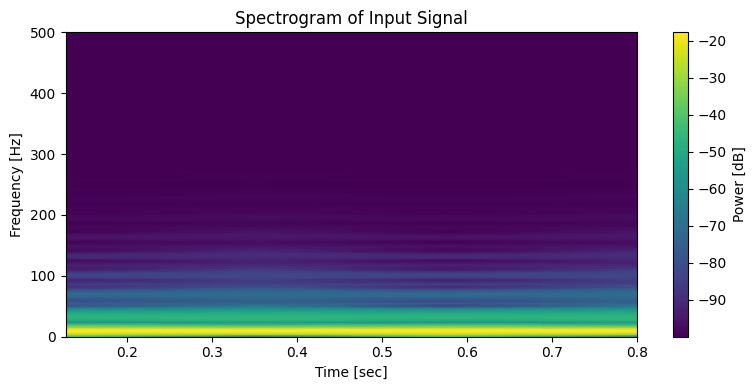

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display, clear_output
from scipy.signal import spectrogram
import ipywidgets as widgets
import time


# --- Quantization Function ---
def quantize(voltage, bits, v_min, v_max):
    levels = 2 ** bits
    step = (v_max - v_min) / levels
    # Clamp voltage to range before quantizing to avoid extrapolation
    voltage_clamped = np.clip(voltage, v_min, v_max)
    quantized = round((voltage_clamped - v_min) / step) * step + v_min
    return quantized, step


# --- Easing Function (Ease In-Out Cubic) ---
def ease_in_out(t):
    return 3 * t**2 - 2 * t**3


# --- Widgets ---
v_min_widget = widgets.FloatText(value=0.0, description="Min V:")
v_max_widget = widgets.FloatText(value=5.0, description="Max V:")
voltage_widget = widgets.FloatText(value=2.5, description="Analog V:")
bits_widget = widgets.IntText(value=3, description="Bits:")
sample_rate_widget = widgets.FloatText(value=1.0, description="Sample Rate (kHz):")
run_button = widgets.Button(description="Start Quantization")
output_warning = widgets.HTML(value="")        # For warnings
output_quantized = widgets.HTML(value="")      # For quantized value display


# --- UI Layout ---
ui = widgets.VBox([
    v_min_widget,
    v_max_widget,
    voltage_widget,
    bits_widget,
    sample_rate_widget,
    run_button,
    output_warning,
    output_quantized
])
display(ui)


# --- Callback ---
def on_button_click(b):
    clear_output(wait=True)
    display(ui)

    # Get values
    v_min = v_min_widget.value
    v_max = v_max_widget.value
    voltage = voltage_widget.value
    bits = bits_widget.value
    sample_rate_khz = sample_rate_widget.value

    # Input validation
    if v_max <= v_min:
        output_warning.value = "<b style='color:red'>Error: Max V must be greater than Min V.</b>"
        output_quantized.value = ""
        return
    if bits < 1:
        output_warning.value = "<b style='color:red'>Error: Bits must be at least 1.</b>"
        output_quantized.value = ""
        return
    if sample_rate_khz <= 0:
        output_warning.value = "<b style='color:red'>Error: Sample rate must be positive.</b>"
        output_quantized.value = ""
        return

    # Check if voltage is outside range
    if voltage < v_min or voltage > v_max:
        output_warning.value = (
            f"<b style='color:orange'>Warning: Input voltage {voltage} V outside range [{v_min}, {v_max}]. "
            "It will be clamped for quantization.</b>"
        )
    else:
        output_warning.value = ""

    # Quantize (clamping inside quantize function)
    q_val, step = quantize(voltage, bits, v_min, v_max)
    error = voltage - q_val
    levels = np.linspace(v_min, v_max, 2 ** bits)

    # Update quantized value output
    output_quantized.value = (
        f"<b>Quantized Value:</b> {q_val:.4f} V<br>"
        f"<b>Quantization Error:</b> {error:.4f} V"
    )

    # Determine y-axis limits dynamically to fit voltage & quantized point with margin
    y_min = min(v_min, voltage, q_val) - 0.5
    y_max = max(v_max, voltage, q_val) + 0.5

    # --- Animation Setup ---
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title("Quantization Animation")
    ax.set_xlim(0, 1)
    ax.set_ylim(y_min, y_max)

    for level in levels:
        ax.hlines(level, 0, 1, colors='lightgray', linestyles='dotted')

    analog_dot, = ax.plot([], [], 'bo', label='Analog Voltage')
    quant_dot, = ax.plot([], [], 'ro', label='Quantized Value')
    error_arrow = ax.annotate('', xy=(0.5, 0), xytext=(0.5, 0),
                              arrowprops=dict(arrowstyle='<->', color='red'),
                              fontsize=12)
    ax.legend()

    frames = 60
    t_vals = np.linspace(0, 1, frames)
    eased_voltages = y_min + (voltage - y_min) * ease_in_out(t_vals)  # Ease from y_min for visible animation

    def init():
        analog_dot.set_data([], [])
        quant_dot.set_data([], [])
        error_arrow.set_visible(False)
        return analog_dot, quant_dot, error_arrow

    def update(frame):
        analog_dot.set_data([0.5], [eased_voltages[frame]])
        if frame == frames - 1:
            quant_dot.set_data([0.5], [q_val])

            # Draw error arrow only if there is an error (non-zero)
            if abs(error) > 1e-9:
                error_arrow.set_visible(True)
                error_arrow.set_position((0.5, (voltage + q_val) / 2))
                error_arrow.xy = (0.5, voltage)
                error_arrow.xytext = (0.5, q_val)
                error_arrow.set_text(f"Error: {error:.2f} V")
            else:
                error_arrow.set_visible(False)
        return analog_dot, quant_dot, error_arrow

    ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init,
                                  blit=True, repeat=False)

    plt.close(fig)
    display(HTML(ani.to_jshtml()))

    # --- Pause before showing spectrogram ---
    time.sleep(1.2)

    # --- Spectrogram ---
    t = np.linspace(0, 1, 1000)
    # Normalize voltage for amplitude scaling between 0 and 1
    norm_voltage = np.clip((voltage - v_min) / (v_max - v_min), 0, 1)
    signal = np.sin(2 * np.pi * 10 * t) * norm_voltage
    fs = int(sample_rate_khz * 1000)
    f, t_spec, Sxx = spectrogram(signal, fs=fs)

    plt.figure(figsize=(8, 4))
    plt.title("Spectrogram of Input Signal")
    plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Power [dB]')
    plt.tight_layout()
    plt.show()


run_button.on_click(on_button_click)